In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
css1 = pd.read_csv('density=0.01.csv')
css1.head()
css1.shape

In [2]:
css1.columns

Index(['timestep', 'agent_0_x', 'agent_0_y', 'agent_0_orig_distance',
       'agent_1_x', 'agent_1_y', 'agent_1_orig_distance', 'agent_2_x',
       'agent_2_y', 'agent_2_orig_distance', 'agent_3_x', 'agent_3_y',
       'agent_3_orig_distance', 'agent_4_x', 'agent_4_y',
       'agent_4_orig_distance', 'agent_5_x', 'agent_5_y',
       'agent_5_orig_distance', 'agent_6_x', 'agent_6_y',
       'agent_6_orig_distance', 'agent_7_x', 'agent_7_y',
       'agent_7_orig_distance', 'agent_8_x', 'agent_8_y',
       'agent_8_orig_distance', 'agent_9_x', 'agent_9_y',
       'agent_9_orig_distance', 'agent_10_x', 'agent_10_y',
       'agent_10_orig_distance', 'agent_11_x', 'agent_11_y',
       'agent_11_orig_distance', 'agent_12_x', 'agent_12_y',
       'agent_12_orig_distance', 'gate0_x', 'gate0_y', 'gate0_orig_distance',
       'gate1_x', 'gate1_y', 'gate1_orig_distance'],
      dtype='object')

In [6]:
column_x = []
column_x.append('agent_0_x')

for i in range(1,37,3):
  i=i+3
  print(css1.columns[i])
  column_x.append(css1.columns[i])
print(column_x)

agent_1_x
agent_2_x
agent_3_x
agent_4_x
agent_5_x
agent_6_x
agent_7_x
agent_8_x
agent_9_x
agent_10_x
agent_11_x
agent_12_x
['agent_0_x', 'agent_1_x', 'agent_2_x', 'agent_3_x', 'agent_4_x', 'agent_5_x', 'agent_6_x', 'agent_7_x', 'agent_8_x', 'agent_9_x', 'agent_10_x', 'agent_11_x', 'agent_12_x']


In [7]:
nan_list = []
for x in column_x:
  nan_list.append(css1[x].isna().idxmax(1))
print(nan_list)
len(nan_list)

[879, 693, 634, 0, 806, 557, 530, 608, 485, 436, 744, 377, 321]


13

In [10]:
df_nan = pd.DataFrame(nan_list)
df_nan['agent']=df_nan.index+1
df_nan.columns=['timestep','agent']
df_nan

,timestep,agent
0,879,1
1,693,2
2,634,3
3,0,4
4,806,5
5,557,6
6,530,7
7,608,8
8,485,9
9,436,10


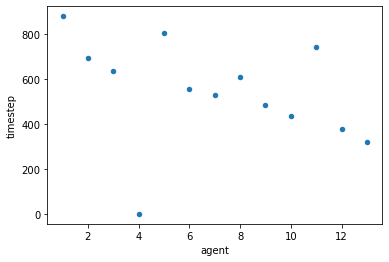

In [14]:
df_nan.plot(x='agent',y='timestep',kind='scatter')
plt.show()

In [48]:
"""
density
"""
directory = "data/log/density/10runs0-0.2/"
# for filename in os.listdir(directory):
#     print(filename)

filename = "density=0.01.i=3.csv"
df = pd.read_csv(f'data/log/density/10runs0-0.2/{filename}')

for column in df.columns:
    if 'gate' in column:
        df = df.drop(columns=column)

orig_dist = df.filter(regex='distance')
orig_dist = list(orig_dist.iloc[1])

# for column in df.columns:
#     if 'distance' in column:
#         df = df.drop(columns=column)

df.columns

nans = []
# df['agent_0_x'].isna().idxmax(1)
for i in range(1, len(df.columns), 3):
    # start with agent_0_x with steps of 3
    first_nan = df[df.columns[i]].isna().idxmax(1)
    nans.append(first_nan)
    
nans[nans.index(0)] = df.timestep.iat[-1]

print(nans)
print(orig_dist)

# outflux = max timestep / n agents
# average velocity
# per agent: orig dist / timestep nans
# voor systeem: average velocity van alle agents
# nog een velocity, als een agent bij andere agents staat of die dan langzamer gaat
# dus velocity aan de hand van hoeveel agents in zn buurt zijn

# over dataframe per x rows, de velocity over de duur van de run meten.

[703, 872, 1043, 479, 316, 669, 801, 611, 408, 751, 926, 846, 975]
[60.12904388032896, 71.86126766005205, 87.18992208947756, 38.13508438602441, 21.713529505444523, 66.04297523583541, 67.94884075757038, 53.133755027940005, 32.82332876531412, 69.29275991943503, 74.09966493294898, 69.42855599735451, 82.99618675684097]


In [4]:
import numba as nb

@nb.njit(fastmath=True)
def dist(pos1, pos2):
    x = np.array(pos1) - np.array(pos2)
    return np.sqrt(x.dot(x))

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

densities = np.arange(0.01, 0.20, 0.01)
iterations = range(0,10)

# Velocities, leavetime/(startingdistance)
# Outflux, (total sim time)/(agents at start)
# Active average distance between agents; pairwise distances
# kijk voor ierede agent elke 2 timesteps wat zijn gemiddelde afstand is tot andere agents

# Active average Velocity: (position change)/(20 timesteps)

### Output: PER iteratie
# Average Velocity
# Outlfux
# Leave time from agents (nan list)
# Original_distance

"""
voor alle densities 1 rij in een dataframe, met min max en avg

bram?
voor alle densities 1 df die van alle iteraties de avg distance heeft per 20 timesteps
"""

for d in densities:
    # columns = ['timestep']
    # columns.extend([f'iteration_{i}_avg_dist_timestep' for i in range(10)])
    distance_df = pd.DataFrame()

    print(distance_df)

    for iteration in iterations:
        df = pd.read_csv(f'../data/log/density/10runs0-0.2/density={d:.2f}.i={iteration}.csv')
        
        gates_excluded = [x for x in df.columns if "gate" not in x]
        
        orig_dist = df[gates_excluded].filter(regex='distance')
        orig_dist = list(orig_dist.iloc[1])
        
        agent_locations = [x for x in gates_excluded if "orig_distance" not in x]
        df = df[agent_locations]
        
        nans = []
        for column in range(1,len(df.columns),2):
            first_nan = df[df.columns[column]].isna().idxmax(1)
            nans.append(first_nan)
    
        nans[nans.index(0)] = df.timestep.iat[-1]

        outflux = (len(agent_locations)/2) / max(nans)

        average_velocity = np.array(orig_dist) / np.array(nans)

        # print(outflux, 1/outflux)
        # print(average_velocity)

        # df_nan = pd.DataFrame(nans)
        # df_nan['agent']=df_nan.index+1
        # df_nan.columns=['timestep','agent']

        # columns = ['timestep']
        # columns.extend([f'agent_{i}_avg_dist' for i in range((len(df.columns)-1)//2)])
        # distance_df = pd.DataFrame(columns=columns)

        steps = 20
        step = 0

        # every x steps add average distance of all agents
        avg_dist_timestep = []
        timesteps = []
        avg_velo_timestep = []

        # so now for every x steps we get an average distance for one agent to the others
        for index, row in df.iterrows():
            if step % steps == 0:
                average_distances = []

                # avg distance
                for j in range(1, len(row), 2):
                    distance = 0
                    amount_of_distances = 0

                    agent_x = row[j]
                    agent_y = row[j+1]
                    if np.isnan(agent_x) or np.isnan(agent_y):
                        continue

                    for k in range(1, len(row), 2):
                        if row[k] == agent_x or np.isnan(row[k]) or np.isnan(row[k+1]):
                            continue
                        
                        amount_of_distances += 1
                        pos1 = (agent_x, agent_y)
                        pos2 = (row[k], row[k+1])
                        distance += dist(pos1, pos2)
                    
                    if amount_of_distances > 0:
                        average_distance = distance / amount_of_distances
                        average_distances.append(average_distance)   
                
                if len(average_distances) > 0:
                    timesteps.append(step)
                    avg_dist_timestep.append(np.nanmean(average_distances))

                # avg velocity
                velocities = []
                if step >= 20:

                    for q in range(1, len(row), 2):
                        current_x = row[q]
                        current_y = row[q+1]
                        old_x = prev_row[q]
                        old_y = prev_row[q+1]

                        if np.isnan(current_x) or np.isnan(current_y) or np.isnan(old_x) or np.isnan(old_y):
                            continue

                        pos1 = (current_x, current_y)
                        pos2 = (old_x, old_y)

                        avg_velo = dist(pos1, pos2) / steps
                        velocities.append(avg_velo)
                    
                avg_velo_timestep.append(np.nanmean(velocities)) if len(velocities) != 0 else avg_velo_timestep.append(np.nan)

                prev_row = row

            step += 1
        # if len(timesteps) > len(distance_df['timestep']):
        df5 = pd.DataFrame({'timestep':timesteps})
        df6 = pd.DataFrame({f"iteration_{iteration}_avg_dist_timestep":avg_dist_timestep})
        df7 = pd.DataFrame({f"iteration_{iteration}_avg_velo_timestep":avg_velo_timestep})
        distance_df = pd.concat([distance_df, df5, df6, df7], axis=1)
        # distance_df.columns=columns
        # distance_df[f'iteration_{i}_avg_dist_timestep'] = pd.Series(avg_dist_timestep)


    break


Empty DataFrame
Columns: []
Index: []


In [ ]:
distance_df = distance_df.loc[:,~distance_df.columns.duplicated()]
distance_df

,timestep,iteration_0_avg_dist_timestep,iteration_0_avg_velo_timestep,iteration_1_avg_dist_timestep,iteration_1_avg_velo_timestep,iteration_2_avg_dist_timestep,iteration_2_avg_velo_timestep,iteration_3_avg_dist_timestep,iteration_3_avg_velo_timestep,iteration_4_avg_dist_timestep,iteration_4_avg_velo_timestep,iteration_5_avg_dist_timestep,iteration_5_avg_velo_timestep,iteration_6_avg_dist_timestep,iteration_6_avg_velo_timestep,iteration_7_avg_dist_timestep,iteration_7_avg_velo_timestep,iteration_8_avg_dist_timestep,iteration_8_avg_velo_timestep,iteration_9_avg_dist_timestep,iteration_9_avg_velo_timestep
0,0.0,43.686057,NaN,52.851917,NaN,47.050266,NaN,46.634562,NaN,50.922394,NaN,50.507296,NaN,56.835390,NaN,59.096717,NaN,47.405731,NaN,42.119585,NaN
1,20.0,42.352162,0.104905,51.286293,0.100234,46.013631,0.100435,45.640601,0.102181,49.391830,0.102321,49.190930,0.101157,55.489416,0.101608,57.320704,0.105384,46.407397,0.100970,40.744094,0.102434
2,40.0,41.028455,0.104174,49.760593,0.101152,44.961193,0.098705,44.613977,0.100295,47.880100,0.101830,47.914784,0.099832,54.175843,0.101862,55.607832,0.102843,45.403269,0.101002,39.355453,0.099733
3,60.0,39.657358,0.105087,48.243526,0.101219,43.915409,0.098017,43.546440,0.100904,46.433059,0.100858,46.658682,0.098197,52.889120,0.101019,53.883783,0.102210,44.421773,0.100491,38.119040,0.100635
4,80.0,38.299301,0.102720,46.736551,0.101536,42.912779,0.097705,42.449822,0.102046,44.960073,0.100509,45.442168,0.097281,51.621405,0.100711,52.206184,0.099400,43.457817,0.100294,36.896281,0.100863
5,100.0,36.979930,0.101236,45.247822,0.101193,41.956156,0.097719,41.372663,0.101522,43.480635,0.100114,44.227936,0.096658,50.366458,0.100758,50.529380,0.098316,42.520047,0.100026,35.703123,0.100558
6,120.0,35.652270,0.101041,43.778113,0.101173,41.024129,0.097131,40.297243,0.101808,41.996174,0.100005,42.955378,0.094848,46.887320,0.100686,49.112129,0.100099,41.586454,0.099787,34.530369,0.100544
7,140.0,34.311941,0.100559,42.324928,0.101148,40.184482,0.100130,39.232031,0.102162,40.600256,0.100299,41.734858,0.094946,45.486800,0.100789,47.729131,0.100670,40.655838,0.099724,33.371484,0.100167
8,160.0,32.976006,0.100472,39.527572,0.100528,38.975873,0.099388,38.180044,0.101738,39.259345,0.101053,40.606716,0.096306,44.097853,0.100803,46.386757,0.100325,39.742891,0.099481,31.384669,0.099718
9,180.0,31.654496,0.100787,37.901367,0.100246,38.111776,0.102035,37.141324,0.101529,37.934231,0.101731,39.524146,0.097865,42.721505,0.100816,45.118749,0.101946,38.872284,0.099726,30.156695,0.097378


In [17]:
distance_df

,timestep,iteration_0_avg_dist_timestep,iteration_0_avg_velo_timestep,iteration_1_avg_dist_timestep,iteration_1_avg_velo_timestep,iteration_2_avg_dist_timestep,iteration_2_avg_velo_timestep,iteration_3_avg_dist_timestep,iteration_3_avg_velo_timestep,iteration_4_avg_dist_timestep,iteration_4_avg_velo_timestep,iteration_5_avg_dist_timestep,iteration_5_avg_velo_timestep,iteration_6_avg_dist_timestep,iteration_6_avg_velo_timestep,iteration_7_avg_dist_timestep,iteration_7_avg_velo_timestep,iteration_8_avg_dist_timestep,iteration_8_avg_velo_timestep,iteration_9_avg_dist_timestep,iteration_9_avg_velo_timestep
0,0.0,43.686057,NaN,52.851917,NaN,47.050266,NaN,46.634562,NaN,50.922394,NaN,50.507296,NaN,56.835390,NaN,59.096717,NaN,47.405731,NaN,42.119585,NaN
1,20.0,42.352162,NaN,51.286293,NaN,46.013631,NaN,45.640601,NaN,49.391830,NaN,49.190930,NaN,55.489416,NaN,57.320704,NaN,46.407397,NaN,40.744094,NaN
2,40.0,41.028455,0.104174,49.760593,0.101152,44.961193,0.098705,44.613977,0.100295,47.880100,0.101830,47.914784,0.099832,54.175843,0.101862,55.607832,0.102843,45.403269,0.101002,39.355453,0.099733
3,60.0,39.657358,0.105087,48.243526,0.101219,43.915409,0.098017,43.546440,0.100904,46.433059,0.100858,46.658682,0.098197,52.889120,0.101019,53.883783,0.102210,44.421773,0.100491,38.119040,0.100635
4,80.0,38.299301,0.102720,46.736551,0.101536,42.912779,0.097705,42.449822,0.102046,44.960073,0.100509,45.442168,0.097281,51.621405,0.100711,52.206184,0.099400,43.457817,0.100294,36.896281,0.100863
5,100.0,36.979930,0.101236,45.247822,0.101193,41.956156,0.097719,41.372663,0.101522,43.480635,0.100114,44.227936,0.096658,50.366458,0.100758,50.529380,0.098316,42.520047,0.100026,35.703123,0.100558
6,120.0,35.652270,0.101041,43.778113,0.101173,41.024129,0.097131,40.297243,0.101808,41.996174,0.100005,42.955378,0.094848,46.887320,0.100686,49.112129,0.100099,41.586454,0.099787,34.530369,0.100544
7,140.0,34.311941,0.100559,42.324928,0.101148,40.184482,0.100130,39.232031,0.102162,40.600256,0.100299,41.734858,0.094946,45.486800,0.100789,47.729131,0.100670,40.655838,0.099724,33.371484,0.100167
8,160.0,32.976006,0.100472,39.527572,0.100528,38.975873,0.099388,38.180044,0.101738,39.259345,0.101053,40.606716,0.096306,44.097853,0.100803,46.386757,0.100325,39.742891,0.099481,31.384669,0.099718
9,180.0,31.654496,0.100787,37.901367,0.100246,38.111776,0.102035,37.141324,0.101529,37.934231,0.101731,39.524146,0.097865,42.721505,0.100816,45.118749,0.101946,38.872284,0.099726,30.156695,0.097378
